# Лабораторная работа 3. 
# Сетевые алгоритмы. Динамические алгоритмы поиска путей.


## Выполнил студент группы Курмашев Данил БПИ2303
***

### Задание

1.  Реализовать алгоритм поиска кратчайшего расстояния между двумя вершинами ориентированного взвешенного графа в соответствии с вариантом. 

2.  Предусмотреть задание графа в виде матрицы смежности/инцидентности, читаемой из файла, либо графически с помощью пользовательского интерфейса. 

3.  Разработать графический интерфейс пользователя с визуализацией графа и отображением кратчайшего расстояния между задаваемыми пользователем вершинами.

4. По результатам работы проанализировать временную сложность работы заданного алгоритма в зависимости от числа узлов и ребер графа.
Данные представить в виде таблицы.



### Алгоритмы:

Алгоритм Джонсона



### Выполнение:

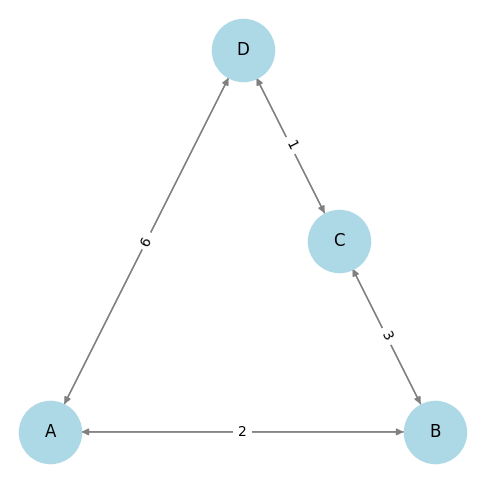

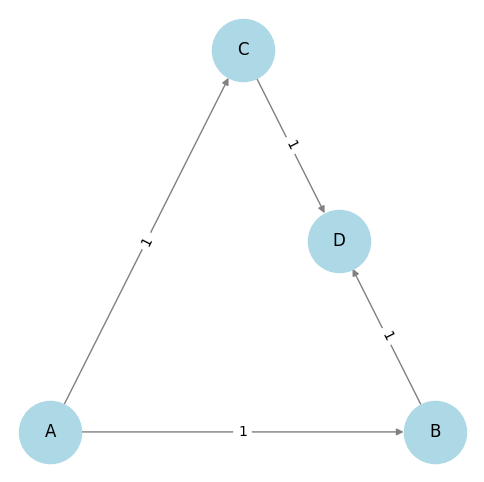

In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox, simpledialog, Toplevel
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import heapq
import time
import numpy as np
import pandas as pd
import scipy

graph = {}
graph_shown = False
graph_window = None

def bellman_ford(graph, start):
    """Алгоритм Беллмана-Форда"""
    distances = {node: float('inf') for node in graph}
    distances[start] = 0

    for _ in range(len(graph) - 1):
        for u in graph:
            for v, weight in graph[u].items():
                if distances[u] + weight < distances[v]:
                    distances[v] = distances[u] + weight

    for u in graph:
        for v, weight in graph[u].items():
            if distances[u] + weight < distances[v]:
                return None

    return distances

def dijkstra(graph, start):
    """Алгоритм Дейкстры"""
    distances = {node: float('inf') for node in graph}
    distances[start] = 0
    pq = [(0, start)]

    while pq:
        current_distance, current_node = heapq.heappop(pq)

        if current_distance > distances[current_node]:
            continue

        for neighbor, weight in graph[current_node].items():
            distance = current_distance + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                heapq.heappush(pq, (distance, neighbor))

    return distances

def johnson(graph):
    """Алгоритм Джонсона"""
    new_graph = {node: graph[node].copy() for node in graph}
    new_graph["Q"] = {node: 0 for node in graph}

    h = bellman_ford(new_graph, "Q")
    if h is None:
        raise ValueError("Граф содержит отрицательный цикл!")

    reweighted_graph = {u: {} for u in graph}
    for u in graph:
        for v, weight in graph[u].items():
            reweighted_graph[u][v] = weight + h[u] - h[v]

    shortest_paths = {}
    for node in graph:
        distances = dijkstra(reweighted_graph, node)
        shortest_paths[node] = {v: distances[v] + h[v] - h[node] for v in distances}

    return shortest_paths

def show_graph(path=None):
    """Пересоздает окно и отображает граф"""
    global graph_window

    if graph_window and tk.Toplevel.winfo_exists(graph_window):
        graph_window.destroy()

    graph_window = Toplevel(root)
    graph_window.title("Граф")

    fig, ax = plt.subplots(figsize=(6, 6))
    G = nx.DiGraph()

    for u in graph:
        for v, weight in graph[u].items():
            G.add_edge(u, v, weight=weight)

    pos = nx.planar_layout(G) if nx.check_planarity(G)[0] else nx.spring_layout(G)

    nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=12)

    edge_labels = {(u, v): f"{graph[u][v]}" for u in graph for v in graph[u]}
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=edge_labels)

    if path:
        path_edges = list(zip(path, path[1:]))
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=path_edges, edge_color='red', width=2)

    canvas = FigureCanvasTkAgg(fig, master=graph_window)
    canvas.get_tk_widget().pack()
    canvas.draw()


def create_graph():
    """Открывает окно для генерации случайного графа"""
    global graph

    create_window = Toplevel(root)
    create_window.title("Создать граф")

    tk.Label(create_window, text="Количество вершин:").pack()
    entry_nodes = tk.Entry(create_window)
    entry_nodes.pack()
    
    tk.Label(create_window, text="Вероятность рёбер (0-1):").pack()
    entry_prob = tk.Entry(create_window)
    entry_prob.pack()

    def generate_graph():
        global graph
        try:
            num_nodes = int(entry_nodes.get())
            edge_probability = float(entry_prob.get())

            nodes = [chr(65 + i) for i in range(num_nodes)]
            graph = {node: {} for node in nodes}

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if i != j and (np.random.rand() < edge_probability or len(graph[nodes[i]]) == 0):
                        weight = np.random.randint(1, 10)
                        graph[nodes[i]][nodes[j]] = weight

            messagebox.showinfo("Генерация", "Случайный граф создан!")
            create_window.destroy()
            show_graph()

        except ValueError:
            messagebox.showerror("Ошибка", "Введите корректные параметры!")

    tk.Button(create_window, text="Создать", command=generate_graph).pack()


def get_shortest_path_edges(start, end, shortest_paths):
    """Возвращает список рёбер, образующих кратчайший путь"""
    path = [start]
    current = start
    visited = set()

    while current != end:
        if current in visited:
            messagebox.showerror("Ошибка", "Ошибка в алгоритме: зацикливание!")
            return []
        
        visited.add(current)

        next_nodes = [node for node in graph[current] if node in shortest_paths[current]]
        if not next_nodes:
            messagebox.showerror("Ошибка", "Путь обрывается, граф может быть несвязным!")
            return []

        next_node = min(next_nodes, key=lambda node: shortest_paths[current][node])
        path.append(next_node)
        current = next_node

    return path



def find_shortest_path():
    """Открывает окно для поиска кратчайшего пути и выделяет маршрут на графе"""
    path_window = Toplevel(root)
    path_window.title("Поиск пути")

    tk.Label(path_window, text="Начальная вершина:").pack()
    entry_start = tk.Entry(path_window)
    entry_start.pack()
    
    tk.Label(path_window, text="Конечная вершина:").pack()
    entry_end = tk.Entry(path_window)
    entry_end.pack()

    def compute_path():
        start = entry_start.get().upper()
        end = entry_end.get().upper()

        if start not in graph or end not in graph:
            messagebox.showerror("Ошибка", "Некорректные вершины!")
            return

        try:
            shortest_paths = johnson(graph)
            if end in shortest_paths[start]:
                messagebox.showinfo("Результат", f"Кратчайшее расстояние {start} → {end}: {shortest_paths[start][end]}")
                show_graph(path=get_shortest_path_edges(start, end, shortest_paths))
            else:
                messagebox.showwarning("Предупреждение", "Пути не существует!")
        except ValueError as e:
            messagebox.showerror("Ошибка", str(e))

    tk.Button(path_window, text="Найти путь", command=compute_path).pack()

def parse_adjacency_matrix(matrix):
    """Парсинг матрицы смежности в граф"""
    global graph
    num_nodes = len(matrix)
    nodes = [chr(65 + i) for i in range(num_nodes)]
    graph = {node: {} for node in nodes}

    for i in range(num_nodes):
        for j in range(num_nodes):
            if matrix[i][j] > 0:
                graph[nodes[i]][nodes[j]] = matrix[i][j]

def parse_incidence_matrix(matrix):
    """Парсинг матрицы инцидентности в граф"""
    global graph
    num_nodes = len(matrix)
    num_edges = len(matrix[0])
    nodes = [chr(65 + i) for i in range(num_nodes)]
    graph = {node: {} for node in nodes}

    edges = []
    for j in range(num_edges):
        start, end, weight = None, None, 1
        for i in range(num_nodes):
            if matrix[i][j] == 1:
                if start is None:
                    start = nodes[i]
                else:
                    end = nodes[i]
            elif matrix[i][j] > 1:
                weight = matrix[i][j]

        if start and end:
            graph[start][end] = weight

def load_graph():
    """Загружает граф из файла (матрица смежности или инцидентности, пользователь выбирает тип)"""
    global graph
    file_path = filedialog.askopenfilename(filetypes=[("Текстовые файлы", "*.txt")])

    if not file_path:
        return

    matrix_type = messagebox.askquestion(
        "Выбор типа матрицы", "Вы загружаете матрицу смежности?",
        icon="question"
    )

    try:
        with open(file_path, "r") as file:
            lines = [line.strip() for line in file.readlines() if line.strip()]
        
        if not lines:
            messagebox.showerror("Ошибка", "Файл пуст или содержит некорректные данные!")
            return

        matrix = [list(map(int, line.split())) for line in lines]

        if matrix_type == "yes":
            parse_adjacency_matrix(matrix)
            messagebox.showinfo("Успех", "Граф загружен (матрица смежности)!")
        else:
            parse_incidence_matrix(matrix)
            messagebox.showinfo("Успех", "Граф загружен (матрица инцидентности)!")

        show_graph()

    except Exception as e:
        messagebox.showerror("Ошибка", f"Ошибка при загрузке: {e}")




def analyze_complexity():
    """Анализ временной сложности"""
    analysis_window = Toplevel(root)
    analysis_window.title("Анализ сложности")

    data = {
        "Вершины": list(range(5, 50, 5)),
        "Рёбра": [],
        "Время (сек.)": []
    }

    for num_nodes in data["Вершины"]:
        test_graph = {chr(65 + i): {} for i in range(num_nodes)}
        for i in range(num_nodes):
            for j in range(num_nodes):
                if i != j and np.random.rand() < 0.3:
                    test_graph[chr(65 + i)][chr(65 + j)] = np.random.randint(1, 10)

        start_time = time.time()
        try:
            johnson(test_graph)
        except ValueError:
            continue
        elapsed_time = time.time() - start_time

        data["Рёбра"].append(len(test_graph))
        data["Время (сек.)"].append(elapsed_time)

    df = pd.DataFrame(data)
    fig, ax = plt.subplots(figsize=(6, 4))
    df.plot(x="Вершины", y="Время (сек.)", kind="line", ax=ax)
    
    canvas = FigureCanvasTkAgg(fig, master=analysis_window)
    canvas.get_tk_widget().pack()
    canvas.draw()

root = tk.Tk()
root.title("Алгоритм Джонсона")

buttons = [
    ("Загрузить граф", load_graph),
    ("Создать граф", create_graph),
    ("Найти путь", find_shortest_path),
    ("Показать граф", show_graph),
    ("Анализ сложности", analyze_complexity)
]

for text, command in buttons:
    tk.Button(root, text=text, command=command).pack(side=tk.LEFT, padx=5)

root.mainloop()